# Dataset generation

This notebook explains how to generate the datasets for various designed scenarios in previous notebook.

In [1]:
import pathlib

In [2]:
LIPS_PATH = pathlib.Path().resolve().parent
DATA_PATH = LIPS_PATH / "reference_data"
LOG_PATH = LIPS_PATH / "lips_logs.log"

In [3]:
if not DATA_PATH.exists():
    DATA_PATH.mkdir(mode=511, parents=False)

# LIPS : Learning Industrial physical simulationbenchmark suite: the power grid case

The benchmarking platform (as it can be observed in the Figure below) is composed of three main modules: Data, Benchmarking and Evaluation. As the names suggest, each module is specialized with its own set of functions for a specific task. The Data module is the one that helps to generate different dataset and distributions providing a high flexibility using a set of parameters. Once the datasets are generated, the benchmarking platform will take as entry the generated dataset and perform a required benchmark on it. Each benchmark could be precised via the inputs and outputs required for modeling and prediction. Finally, in order to evaluate the performance of each benchmark, the Evaluation module provides a set of functions to inspect the models from different point of views (physics compliances, machine learning metrics, adaptability and readiness.  

The figure below presents the scheme of benchmarking platform which is composed of three distinct parts : 
* DataSet: Generate some dataset for training and evaluation 
* Benchmark: coordinates between different parts and allows train and evaluate an agumented simulator 
* Evaluation: once the benchmark done, it allow to evaluate the performance with respect to various point of views

![title](img/Benchmarking_scheme_v2.png)

## Benchmark 1 : Risk assessment through contingency screening
The first power grid benchmark tackles the step of risk assessment in power grids. The problem is to anticipate potential threats on the power grid (several hours ahead) and warn the operators accordingly. It simulates incidents (aka contingencies) involving various elements of the grid (such as the disconnection of a line/production unit), one by one. For each contingency, a risk (weakness of the grid) is detected when overloads are detected by the simulation engine on some lines. On a real grid, this scenario means running several dozens of thousands of simulations, thereby, computation time is critical, especially since this risk assessment is refreshed every 15 minutes. In this benchmark, the main physical variable we are interested in is the value of electric current in the lines (in amperes), because an overload is detected if this value exceeds a line-dependent threshold.

First we need to create the associated benchmark:

In [4]:
from lips.benchmark import PowerGridBenchmark
benchmark1 = PowerGridBenchmark(benchmark_path=DATA_PATH,
                                benchmark_name="Benchmark1",
                                load_data_set=False,
                                config_path=None, # opt for default config path (benchmark/config.ini)
                                log_path=LOG_PATH)

2022-05-01 09:18:15.619921: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Then we need to generate the data, note that this step needs to be done only once (by the person in charge of releasing the benchmark).

People that want to use this benchmark are after free to load the data (see the next notebook for an example)

**NB** To generate the datasets, you need extra libraries (for example `grid2op`, `lightsim2grid` or `leap_net`). These libraries are not required to use this platform once the data are generated.

**NB** This process takes a lot of time...

In [5]:
benchmark1.generate(nb_sample_train=int(1e5),
                    nb_sample_val=int(1e4),
                    nb_sample_test=int(1e4),
                    nb_sample_test_ood_topo=int(1e4),
                   )

test_ood_topo: 100%|█████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:08<00:00, 32.36it/s]


## Benchmark 2 : Remedial action search
Once risky contingencies are identified, we need to explore possible solutions (aka "remedial actions") to recommend suitable solutions to the grid operator. In this benchmark, a solution consists in predefined topological change on the grid. It is successful if the simulation run on this modified grid alleviates the previous overflow without generating any new problem. In this case, the computation space in practice is significantly smaller compared to benchmark 1 (only small subsets of remedial actions to test over in most cases, compared to every contingency simulations). We here target  10-100 simulation batches whatever the grid size. This only depends on the number of preselected action candidates by the operator for a given risk. This benchmark includes the prediction of a few more physical variables: active power flows $p^\ell$ (in MW), current $a^\ell$ (in A) voltages $v_{k}$ (in V) at both sides of each powerline. Although this is not sufficient to fully describe the grid from a physical point of view, it is enough to give the operator some confident insights about the underlying physical behavior. For instance, is an overload somehow rather local and related to neighboring voltage drop phenomena or possibly long-distance considering power flow transmission from large power plants?

Firt we need to create the associated benchmark:

In [4]:
from lips.benchmark import PowerGridBenchmark
benchmark2 = PowerGridBenchmark(benchmark_path=DATA_PATH,
                                benchmark_name="Benchmark2",
                                load_data_set=False,
                                config_path=None, # opt for default config path (benchmark/config.ini)
                                log_path=LOG_PATH) 

2022-05-02 19:17:27.736847: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [5]:
benchmark2.generate(nb_sample_train=int(1e5),
                    nb_sample_val=int(1e4),
                    nb_sample_test=int(1e4),
                    nb_sample_test_ood_topo=int(1e4),
                   )

test_ood_topo: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:32<00:00, 30.12it/s]


## Benchmark 3 : Validation of decision
Once preferred solutions have been selected by the operator to alleviate an overflow, a last detailed simulation is run and studied more in depth by the operator, prior to apply the remedial actions on the actual power grid. The purpose of this operation is to ensure that no unforeseen event may make the grid collapse. In this application, the quality of prediction is decisive, to ensure that the adopted interventions will not violate the consistency within the network; therefore the surrogate simulator shall be nearly as good as the numerical solver. Here the main goal is to ensure the accuracy and consistency of the solution for 1-10 simulations. All physical variables of the physical problem shall be predicted: currents $a^\ell$, active power flows $p^\ell$, voltages $v_{k}$, reactive power flows $q^\ell$, angles $\theta_k$.

In [16]:
from lips.benchmark import PowerGridBenchmark
benchmark3 = PowerGridBenchmark(benchmark_path=DATA_PATH,
                                benchmark_name="Benchmark3",
                                load_data_set=False,
                                config_path=None, # opt for default config path (benchmark/config.ini)
                                log_path=LOG_PATH)

In [5]:
benchmark3.generate(nb_sample_train=int(1e5),
                    nb_sample_val=int(1e4),
                    nb_sample_test=int(1e4),
                    nb_sample_test_ood_topo=int(1e4),
                   )

test_ood_topo: 100%|██████████████████████████████████████████████████████████████| 10000/10000 [01:47<00:00, 92.69it/s]


## Visualization
In order to analyze the behavior of the agents used during the generation of datasets, this section provide some visualizations to observe on a power grid how the observations are presented. 

In [6]:
from grid2op.PlotGrid import PlotMatplot
def visualize_obs(env, obs):
    plot_helper = PlotMatplot(env.observation_space)
    fig_custom = plot_helper.plot_obs(obs,
                                      line_info="rho",
                                      load_info=None,  # i don't plot anything concerning the load
                                      gen_info="v"  # i draw the voltage setpoint of the generators
                                      )

### Benchmark1

In [9]:
benchmark1._fills_actor_simulator()

We analyze the out of distribution dataset below. It can be seen, that there are at least two line disconnections, alognside a third disconnection and a topology reconfiguration coming from reference topolgoy.

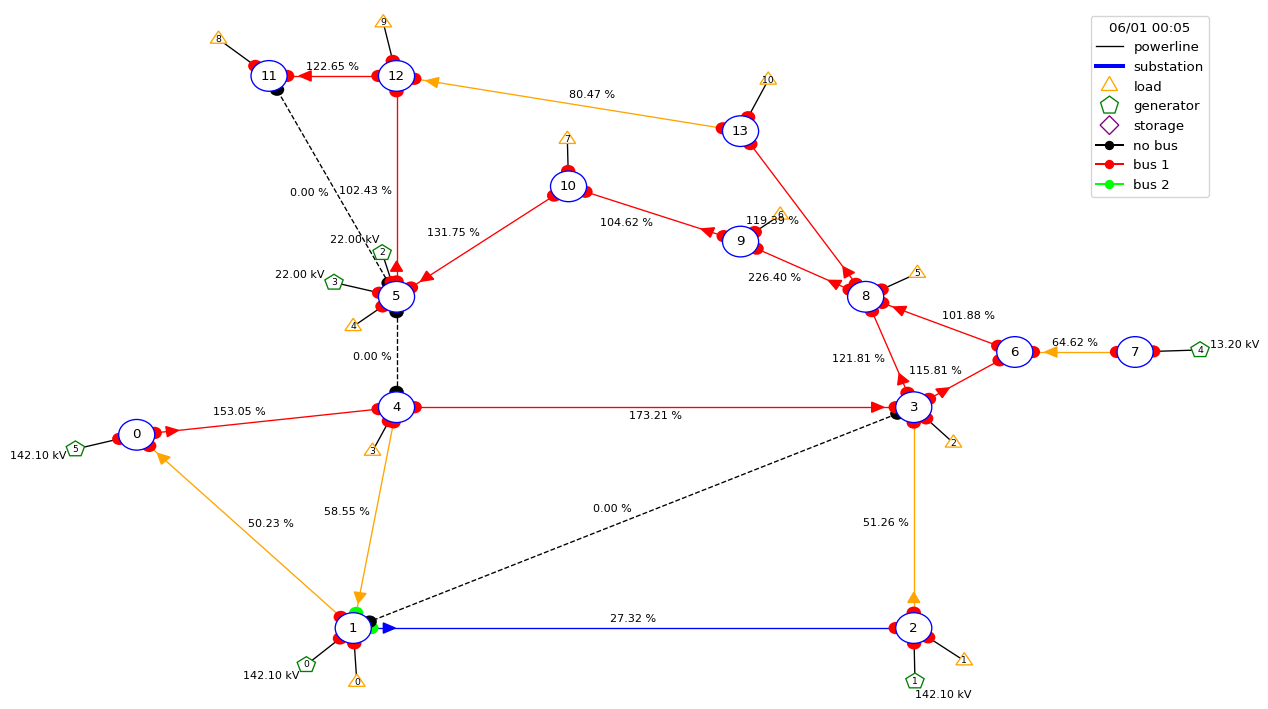

In [12]:
obs = benchmark1.env.reset()
action = benchmark1.test_ood_topo_actor.act(obs)
obs, *_ = benchmark1.env.step(action)
visualize_obs(benchmark1.env, obs)

### Benchmark2

In [14]:
benchmark2._fills_actor_simulator()

We analyze the out of distribution dataset below. As it can be seen, there are at least two topological actions at two substations. The third one comes from the reference topology.

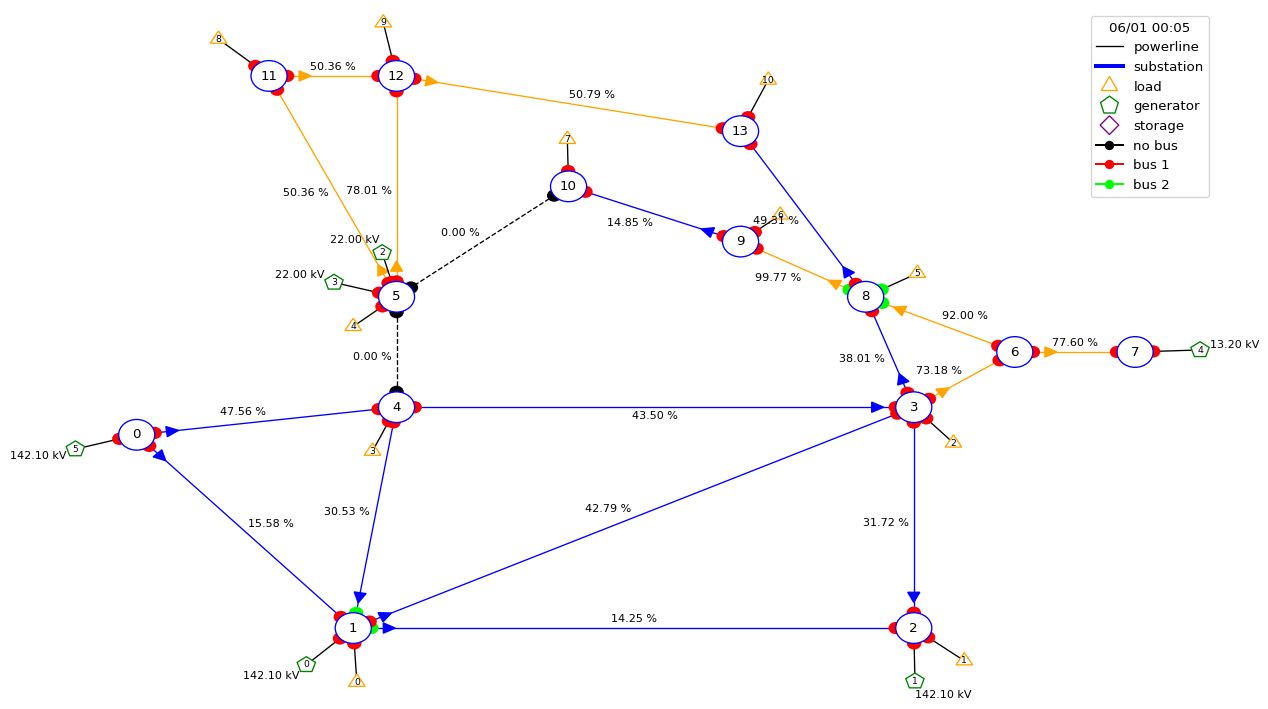

In [18]:
obs = benchmark2.env.reset()
action = benchmark2.test_ood_topo_actor.act(obs)
obs, *_ = benchmark2.env.step(action)
visualize_obs(benchmark2.env, obs)

### Benchmark3 

In [17]:
benchmark3._fills_actor_simulator()

We analyze the out of distribution dataset below. It can be seen that there is a high probability to sample from changes at depth 4 and 5 for out-of-distribution dataset. Here, there are four topology changes and one line disconnection. 

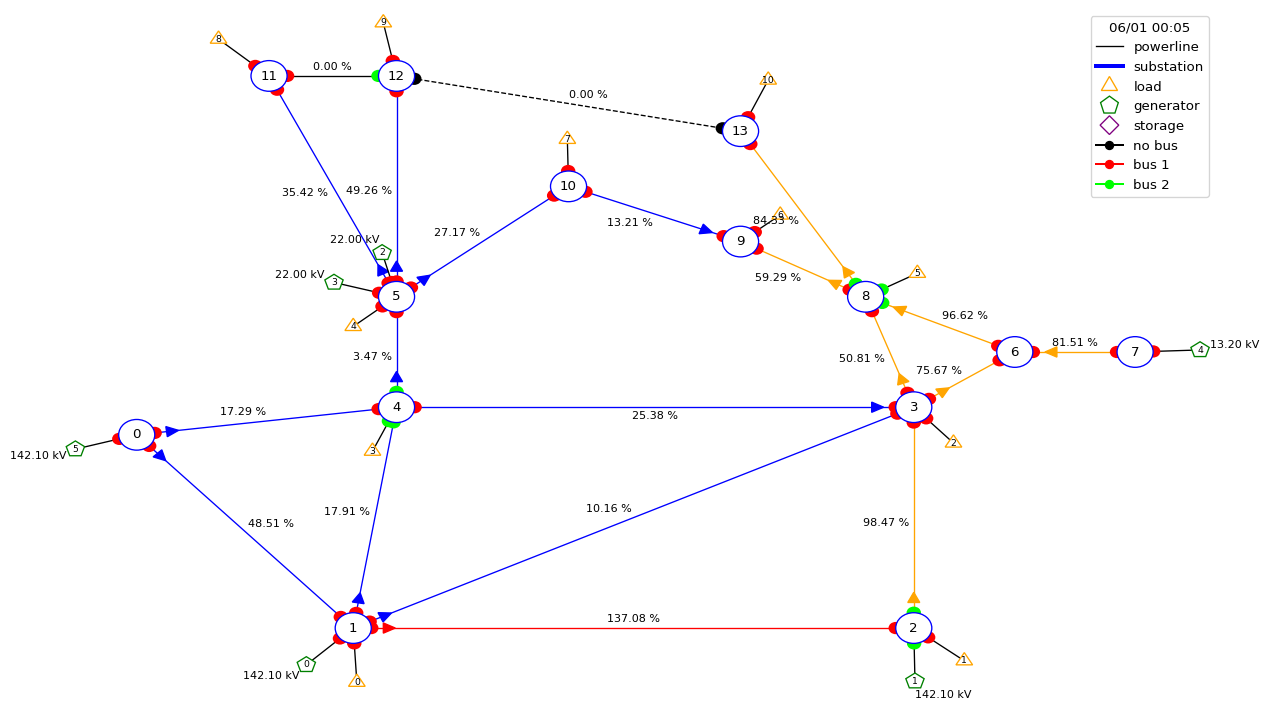

In [19]:
obs = benchmark3.env.reset()
action = benchmark3.test_ood_topo_actor.act(obs)
obs, *_ = benchmark3.env.step(action)
visualize_obs(benchmark3.env, obs)